In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, CLIPTokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from torch.optim import AdamW
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import math

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
import os

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [4]:
#paths
import os

dataset_path= "/kaggle/input/flickr8k"
image_dir= "/kaggle/input/flickr8k/Images"
captions_path= "/kaggle/input/flickr8k/captions.txt"
fine_tuned_clip= "/kaggle/input/fine_tuned_clip/pytorch/default/1/fine_tuned_clip"
fine_tuned_clip_processor= "/kaggle/input/fine_tuned_clip_processor/pytorch/default/1/fine_tuned_clip_processor"


In [5]:
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Image directory not found: {image_dir}")
if not os.path.exists(captions_path):
    raise FileNotFoundError(f"Caption file not found: {captions_path}")

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Load captions
        captions_df = pd.read_csv(captions_file)  # Read the CSV file
        # Strip any whitespace from filenames and captions
        captions_df["image"] = captions_df["image"].str.strip()
        captions_df["caption"] = captions_df["caption"].str.strip()
        self.image_paths = captions_df["image"].tolist()
        self.captions = captions_df["caption"].tolist()

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        # Build full image path
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Retrieve caption
        caption = self.captions[idx]
        return {"image": image, "caption": caption}


In [6]:
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])


In [7]:
dataset = FlickrDataset(image_dir, captions_path, transform=image_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [8]:
# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
# Load pre-trained VAE and U-Net
vae = vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae",torch_dtype=torch.float16).to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",torch_dtype=torch.float16).to(device)


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [10]:
# Define diffusion scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

In [ ]:
# Output directories
output_dir = "/kaggle/working/trained_models1/"
os.makedirs(output_dir, exist_ok=True)

In [35]:


if os.path.exists(clip_model_path):
    model = CLIPModel.from_pretrained(clip_model_path).to(device)
    processor = CLIPProcessor.from_pretrained(clip_model_processor)
else:
    os.makedirs("./fine_tuned_clip", exist_ok=True)
    os.makedirs("./fine_tuned_clip_processor", exist_ok=True)

    # Optimizer
    optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-5)

    num_epochs = 5

    # Training loop
    clip_model.train()
    for epoch in range(num_epochs):  # Number of epochs
        print(f"Epoch {epoch + 1}/{num_epochs}")
        epoch_loss = 0
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for idx, batch in enumerate(dataloader):
                images = batch["image"].to(device)
                captions = batch["caption"]

                # Preprocess text inputs
                text_inputs = clip_processor(text=captions, return_tensors="pt", padding=True).to(device)

                # Forward pass
                outputs = clip_model(
                    pixel_values=images,
                    input_ids=text_inputs.input_ids,
                    attention_mask=text_inputs.attention_mask,
                    return_loss=True
                )
                loss = outputs.loss  # Contrastive loss

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress bar and metrics
                epoch_loss += loss.item()
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

        # Save the fine-tuned model
        clip_model.save_pretrained("./fine_tuned_clip")
        clip_processor.save_pretrained("./fine_tuned_clip_processor")

Epoch 1/5


Epoch 1/5: 100%|██████████| 5057/5057 [1:12:18<00:00,  1.17batch/s, Loss=0.0172]


Epoch 1 Average Loss: 0.0699
Epoch 2/5


Epoch 2/5: 100%|██████████| 5057/5057 [1:11:50<00:00,  1.17batch/s, Loss=0.0001]


Epoch 2 Average Loss: 0.0555
Epoch 3/5


Epoch 3/5: 100%|██████████| 5057/5057 [1:11:38<00:00,  1.18batch/s, Loss=0.0724]


Epoch 3 Average Loss: 0.0485
Epoch 4/5


Epoch 4/5: 100%|██████████| 5057/5057 [1:11:34<00:00,  1.18batch/s, Loss=0.0005]


Epoch 4 Average Loss: 0.0419
Epoch 5/5


Epoch 5/5: 100%|██████████| 5057/5057 [1:11:49<00:00,  1.17batch/s, Loss=0.0029]


Epoch 5 Average Loss: 0.0419


In [36]:
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [29]:
def generate_images(
    vae, unet, text_encoder, tokenizer, scheduler, 
    prompts, 
    height=224, width=224, 
    device="cuda", 
    g=7.5, seed=100, steps=70, dim=512, save_int=True
):


    def encode_text(prompts, maxlen=None):
        if maxlen is None:
            maxlen = tokenizer.model_max_length
        inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
        return text_encoder(inp.input_ids.to(device))[0].half()

    def latents_pil(latents):
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images


    

    prompts_batch_size = len(prompts)
    encoded_text = encode_text(prompts)
    uncond_embed = encode_text([""] * prompts_batch_size, encoded_text.shape[1])
    embed = torch.cat([uncond_embed, encoded_text])

    if seed:
        torch.manual_seed(seed)
    
    latents = torch.randn((prompts_batch_size, unet.config.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i, ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=embed).sample.chunk(2)
        pred = u + g * (t - u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    return latents_pil(latents)



def display_images(images, prompts):

    total_images = len(images)
    n = math.ceil(math.sqrt(total_images))
    rows = (total_images + n - 1) // n

    fig, axs = plt.subplots(rows, n, figsize=(n * 3, rows * 3))
    axs = np.array(axs).reshape(-1)

    for i in range(rows * n):
        if i < total_images:
            axs[i].imshow(images[i])
            axs[i].title.set_text(prompts[i] if prompts[i] else "<No Text>")
            axs[i].axis("off")
        else:
            axs[i].axis("off")

    fig.suptitle("Generated Images: With Fine Tune", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [30]:
def generate_images_without_fine_tune(
    vae, unet, text_without_fine_tune, tokenizer, scheduler, 
    prompts, 
    height=224, width=224, 
    device="cuda", 
    g=7.5, seed=100, steps=70, dim=512, save_int=True
):


    def encode_text(prompts, maxlen=None):
        if maxlen is None:
            maxlen = tokenizer.model_max_length
        inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
        return text_without_fine_tune(inp.input_ids.to(device))[0].half()

    def latents_pil(latents):
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images


    

    prompts_batch_size = len(prompts)
    encoded_text = encode_text(prompts)
    uncond_embed = encode_text([""] * prompts_batch_size, encoded_text.shape[1])
    embed = torch.cat([uncond_embed, encoded_text])

    if seed:
        torch.manual_seed(seed)
    
    latents = torch.randn((prompts_batch_size, unet.config.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device).half() * scheduler.init_noise_sigma

    for i, ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=embed).sample.chunk(2)
        pred = u + g * (t - u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    return latents_pil(latents)



def display_images_without_fine_tune(images, prompts):

    total_images = len(images)
    n = math.ceil(math.sqrt(total_images))
    rows = (total_images + n - 1) // n

    fig, axs = plt.subplots(rows, n, figsize=(n * 3, rows * 3))
    axs = np.array(axs).reshape(-1)
    

    for i in range(rows * n):
        if i < total_images:
            axs[i].imshow(images[i])
            axs[i].title.set_text(prompts[i] if prompts[i] else "<No Text>")
            axs[i].axis("off")
        else:
            axs[i].axis("off")
    
    fig.suptitle("Generated Images: Without Fine Tune", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [18]:
tokenizer = CLIPTokenizer.from_pretrained(fine_tuned_clip_processor)

# Initialize the model
text_encoder = CLIPTextModel.from_pretrained(fine_tuned_clip).to(device)

#without fine tune
text_without_fine_tune= CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

Some weights of the model checkpoint at /kaggle/input/fine_tuned_clip/pytorch/default/1/fine_tuned_clip were not used when initializing CLIPTextModel: ['logit_scale', 'text_projection.weight', 'vision_model.embeddings.class_embedding', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.self_attn.

100%|██████████| 70/70 [00:18<00:00,  3.80it/s]


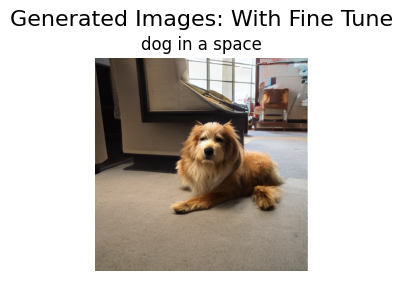

In [31]:
prompts=["dog in a space"] 

images = generate_images(
    vae, unet, text_encoder, tokenizer, scheduler, 
    prompts
)

display_images(images, prompts)

100%|██████████| 70/70 [00:18<00:00,  3.81it/s]


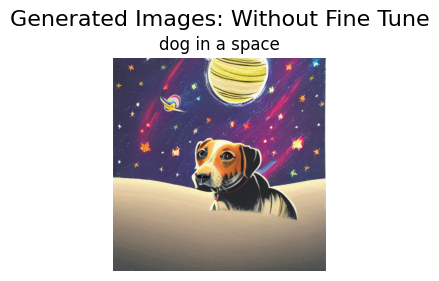

In [32]:
#without fine tune
images = generate_images_without_fine_tune(
    vae, unet, text_without_fine_tune, tokenizer, scheduler, 
    prompts
)

display_images_without_fine_tune(images, prompts)